# Описание проекта. Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

Значение метрики MAE на тестовой выборке должно быть менее 6.8.

## Загрузка данных

### Импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
import phik
import torch.optim as optim

from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from math import ceil
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from skorch import NeuralNetRegressor

In [2]:
import warnings

warnings.simplefilter("ignore", UserWarning)

### Подключение к базе данных

В качестве константы установим дату начала работы над проектом.

In [3]:
RANDOM_STATE = 141123

In [4]:
db_config = {
'user': 'praktikum_student',
'pwd': 'Sdf4$2;d-d30pp',
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,
'db': 'data-science-final'
}

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'], 
                                                         db_config['pwd'], 
                                                         db_config['host'], 
                                                         db_config['port'],
                                                         db_config['db'])

In [6]:
engine = create_engine(connection_string)

## Исследовательский анализ и предобработка данных

### Данные об электродах

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Таблица steel.data_arc содержит данные об электродах:

- key — номер партии;
- BeginHeat — время начала нагрева;
- EndHeat — время окончания нагрева;
- ActivePower — значение активной мощности;
- ReactivePower — значение реактивной мощности.

In [7]:
query = '''SELECT *
           FROM steel.data_arc
        '''

data_arc = pd.read_sql_query(query, con=engine)

In [8]:
data_arc.head(10)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397
5,2,11:34:14,11:36:31,0.438063,0.283043
6,2,11:38:50,11:44:28,1.296415,0.892914
7,2,11:46:19,11:48:25,0.490377,0.305281
8,2,11:49:48,11:53:18,0.827743,0.516874
9,3,12:06:54,12:11:34,1.062053,0.671494


In [9]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [10]:
data_arc.isna().sum()

key              0
BeginHeat        0
EndHeat          0
ActivePower      0
ReactivePower    0
dtype: int64

In [11]:
data_arc.duplicated().sum()

0

Таблица состоит из 14876 строк. Пропусков и повторов не обнаружено.

Проверим, какое количество электродов может использоваться на каждой партии.

In [12]:
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

Вычислим длительность нагрева партии и переведем ее в секунды.

In [13]:
data_arc['BeginHeat'] = pd.to_datetime(data_arc['BeginHeat'], format='%H:%M:%S')
data_arc['EndHeat'] = pd.to_datetime(data_arc['EndHeat'], format='%H:%M:%S')

In [14]:
data_arc['Duration'] = (data_arc['EndHeat'] - data_arc['BeginHeat']).dt.total_seconds()

In [15]:
data_arc.head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,Duration
0,1,1900-01-01 11:02:14,1900-01-01 11:06:02,0.976059,0.687084,228.0
1,1,1900-01-01 11:07:28,1900-01-01 11:10:33,0.805607,0.520285,185.0
2,1,1900-01-01 11:11:44,1900-01-01 11:14:36,0.744363,0.498805,172.0
3,1,1900-01-01 11:18:14,1900-01-01 11:24:19,1.659363,1.062669,365.0
4,1,1900-01-01 11:26:09,1900-01-01 11:28:37,0.692755,0.414397,148.0


In [16]:
data_arc['Duration'].describe()

count    14876.000000
mean        43.894663
std       3319.473237
min     -86330.000000
25%        106.750000
50%        147.000000
75%        214.000000
max        907.000000
Name: Duration, dtype: float64

Мы получили отрицальные значения времени нагрева. Такие данные нужно удалить.

In [17]:
data_arc = data_arc.query('Duration > 0')

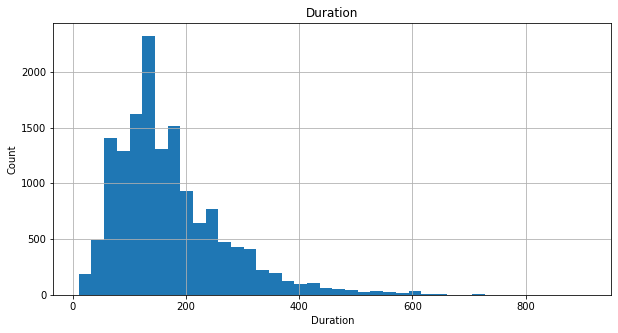

In [18]:
data_arc['Duration'].hist(figsize=(10, 5), bins=40)
plt.title('Duration')
plt.xlabel('Duration')
plt.ylabel('Count')
plt.show()

Также удалим редкие значения на дальнем конце - все что выше 500 секунд. Таких значений слишком мало.

In [19]:
data_arc = data_arc.query('Duration < 500')

In [20]:
data_arc['ActivePower'].describe()

count    14696.000000
mean         0.652150
std          0.369559
min          0.030002
25%          0.392981
50%          0.551343
75%          0.842764
max          2.397369
Name: ActivePower, dtype: float64

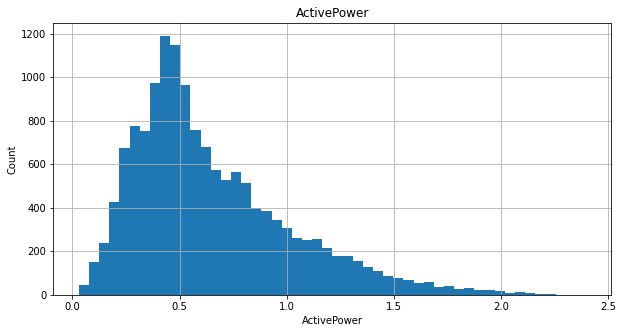

In [21]:
data_arc['ActivePower'].hist(figsize=(10, 5), bins=50)
plt.title('ActivePower')
plt.xlabel('ActivePower')
plt.ylabel('Count')
plt.show()

In [22]:
data_arc = data_arc.query('ActivePower < 2')

Мы также убрали дальние значения активной мощности по той же причине.

In [23]:
data_arc['ReactivePower'].describe()

count    14648.000000
mean         0.434759
std          5.922303
min       -715.504924
25%          0.288087
50%          0.411985
75%          0.624750
max          2.100782
Name: ReactivePower, dtype: float64

In [24]:
data_arc = data_arc.query('ReactivePower > 0')

В данных о реактивной мощности есть отрицательные значения, которые необходимо удалить.

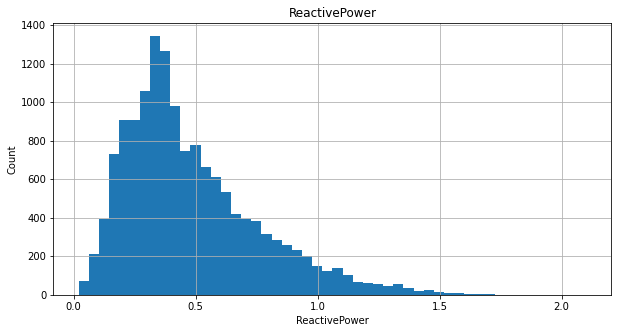

In [25]:
data_arc['ReactivePower'].hist(figsize=(10, 5), bins=50)
plt.title('ReactivePower')
plt.xlabel('ReactivePower')
plt.ylabel('Count')
plt.show()

In [26]:
data_arc = data_arc.query('ReactivePower < 1.5')

Также убрали редкие значения для реактивной мощности.

На основе имеющихся в нашем распоряжении признаков мы может сформировать новые. Например, полная мощность (комбинация активной и реактивной мощностей, формула ниже), а также отношение активной мощности к реактивной.

$ApparentPower = \sqrt {ActivePower^2 + ReactivePower^2}$

In [27]:
data_arc['ApparentPower'] = ((data_arc['ActivePower'] ** 2) + (data_arc['ReactivePower'] ** 2)) ** 0.5

In [28]:
data_arc['Active/Reactive'] = data_arc['ActivePower'] / data_arc['ReactivePower']

После преобразования признаков мы можем удалить некоторые столбцы. Время начала и конца нагрева, так как мы на их основе вычислили время нагрева в секундах, а также активную и реактивную мощность - на их основе были получены производные признаки.

In [29]:
data_arc = data_arc.drop(['BeginHeat', 'EndHeat'], axis=1)

In [30]:
data_arc = data_arc.drop(['ActivePower', 'ReactivePower'], axis=1)

In [31]:
data_arc.head()

,key,Duration,ApparentPower,Active/Reactive
0,1,228.0,1.193639,1.420582
1,1,185.0,0.959010,1.548395
2,1,172.0,0.896038,1.492292
3,1,365.0,1.970470,1.561504
4,1,148.0,0.807239,1.671717


В дальнейшем, по заданию, нам необходимо будет объединить данные в итоговую таблицу так, чтобы одной партии соответствовало одно наблюдение. Соберем первую таблицу так, чтобы для каждого наблюдения были выведены средние значения мощности и времени нагрева для каждого использованного электрода.

In [32]:
data_arc = data_arc.groupby('key').agg({'Duration': 'mean', 
                                        'ApparentPower': 'mean', 
                                        'Active/Reactive': 'mean'})

In [33]:
data_arc.reset_index(inplace=True)

In [34]:
data_arc.head()

,key,Duration,ApparentPower,Active/Reactive
0,1,219.60,1.165279,1.538898
1,2,202.75,0.912304,1.551834
2,3,131.00,0.597907,1.583120
3,4,185.25,0.953741,1.563487
4,5,217.25,1.008939,1.480428


In [35]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              3214 non-null   int64  
 1   Duration         3214 non-null   float64
 2   ApparentPower    3214 non-null   float64
 3   Active/Reactive  3214 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 100.6 KB


### Данные об объеме и времени подачи сыпучих материалов

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

steel.data_bulk — данные об объёме сыпучих материалов:

- key — номер партии;
- Bulk1 … Bulk15 — объём подаваемого материала.

In [36]:
query = '''SELECT *
           FROM steel.data_bulk
        '''

data_bulk = pd.read_sql_query(query, con=engine)

In [37]:
data_bulk.head(15)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [38]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [39]:
data_bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [40]:
data_bulk.duplicated().sum()

0

steel.data_bulk_time — данные о времени подачи сыпучих материалов:

- key — номер партии;
- Bulk1 … Bulk15 — время подачи материала

In [41]:
query = '''SELECT *
           FROM steel.data_bulk_time
        '''

data_bulk_time = pd.read_sql_query(query, con=engine)

In [42]:
data_bulk_time.head(15)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56
5,6,None,None,None,13:59:24,None,None,None,None,None,None,None,13:53:27,None,13:53:27,13:53:27
6,7,None,None,None,14:29:14,None,None,None,None,None,None,None,14:22:19,None,14:22:19,14:22:19
7,8,None,None,None,15:04:05,None,None,None,None,None,None,None,14:55:46,None,14:55:46,14:55:46
8,9,None,None,None,15:47:34,None,None,None,None,None,None,None,15:41:00,None,15:41:00,15:41:00
9,10,None,None,None,None,None,None,None,None,None,None,None,16:18:52,None,16:18:52,16:18:52


In [43]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [44]:
data_bulk_time.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [45]:
data_bulk_time.duplicated().sum()

0

В обеих таблицах нет повторов, но очень большое количество пропусков. Можно предположить, что в процессе обработки такие материалы не играют существенную роль, и для целей нашего исследования их можно удалить, так как в случае дальнейшего использования все пропуски придется чем-то заполнить (как минимум 0), что может исказить данные.

В качестве фильтра возьмем количество пропусков 2500.

In [46]:
data_bulk = data_bulk.fillna(0)
data_bulk_time = data_bulk_time.fillna(0)

In [47]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


### Данные о продувке сплава газом

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.


Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

steel.data_gas — данные о продувке сплава газом:

- key — номер партии
- gas — объём подаваемого газа

In [48]:
query = '''SELECT *
           FROM steel.data_gas
        '''

data_gas = pd.read_sql_query(query, con=engine)

In [49]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [50]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [51]:
data_gas.isna().sum()

key    0
gas    0
dtype: int64

In [52]:
data_gas.duplicated().sum()

0

Пропусков и повторов в данных нет.

In [53]:
data_gas['gas'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64

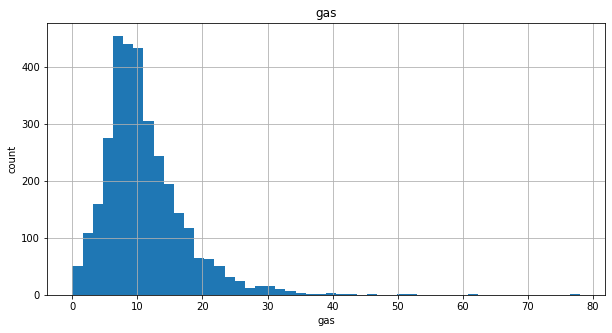

In [54]:
data_gas['gas'].hist(figsize=(10, 5), bins=50)
plt.title('gas')
plt.xlabel('gas')
plt.ylabel('count')
plt.show()

In [55]:
data_gas = data_gas.query('gas < 31')

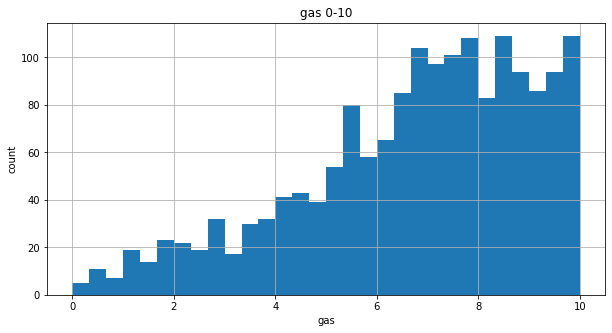

In [56]:
data_gas['gas'].hist(figsize=(10, 5), range=(0, 10), bins=30)
plt.title('gas 0-10')
plt.xlabel('gas')
plt.ylabel('count')
plt.show()

In [57]:
data_gas = data_gas.query('gas > 2')

Мы немного подкорретировали данные убрав редкие значения в начале и конце.

In [58]:
data_gas['gas'].describe()

count    3125.000000
mean       10.940266
std         5.300457
min         2.022229
25%         7.219785
50%         9.884287
75%        13.726516
max        30.836658
Name: gas, dtype: float64

### Данные об измерениях температуры

steel.data_temp — данные об измерениях температуры:

- key — номер партии
- MesaureTime — время замера
- Temperature — значение температуры

In [59]:
query = '''SELECT *
           FROM steel.data_temp
        '''

data_temp = pd.read_sql_query(query, con=engine)

In [60]:
data_temp.head(10)

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0
5,2,11:37:27,1581.0
6,2,11:38:00,1577.0
7,2,11:49:38,1589.0
8,2,11:55:50,1604.0
9,2,11:58:24,1608.0


In [61]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [62]:
data_temp.isna().sum()

key               0
MesaureTime       0
Temperature    2901
dtype: int64

In [63]:
data_temp.duplicated().sum()

0

Есть пропуски в значениях температуры, повторов нет.

Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные, поэтому их необходимо убрать. Также уберем несколько редких значений в начале и конце.

In [64]:
data_temp_null = data_temp[data_temp['Temperature'].isnull()]['key'].unique()
data_temp_wrong = data_temp.query('Temperature < 1500')['key'].unique()

In [65]:
data_temp = data_temp.query('key not in @data_temp_null')
data_temp = data_temp.query('key not in @data_temp_wrong')

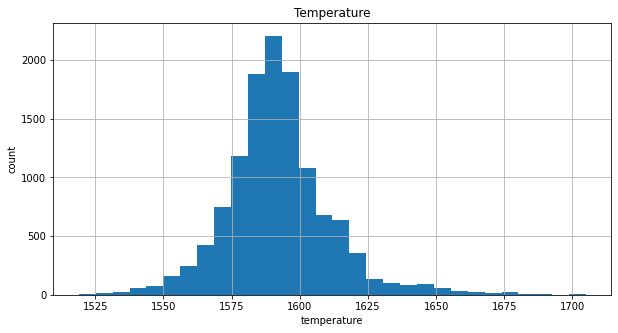

In [66]:
data_temp['Temperature'].hist(figsize=(10, 5), bins=30)
plt.title('Temperature')
plt.xlabel('temperature')
plt.ylabel('count')
plt.show()

In [67]:
data_temp = data_temp.query('Temperature > 1525')

In [68]:
data_temp = data_temp.query('Temperature < 1675')

Целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные.


При агрегировании наблюдений мы будем использовать только ключи, у которых как минимум два наблюдения: первый и последний замеры температуры.

In [69]:
data_temp['key'].value_counts()

44      16
46      16
1513    16
2108    15
1689    15
        ..
1631     2
2214     2
206      2
195      1
279      1
Name: key, Length: 2472, dtype: int64

In [70]:
temp = pd.DataFrame(data_temp['key'].value_counts())
temp.reset_index(inplace=True)
temp.head(10)

,index,key
0,44,16
1,46,16
2,1513,16
3,2108,15
4,1689,15
5,877,14
6,1051,13
7,174,12
8,935,12
9,457,12


In [71]:
temp = temp.rename(columns={'index': 'key', 'key': 'key_count'})

In [72]:
data_temp = data_temp.merge(temp, on='key')
data_temp = data_temp.query('key_count > 1')
data_temp.sample(10)

,key,MesaureTime,Temperature,key_count
4427,884,02:32:37,1594.0,4
8295,1695,19:59:31,1592.0,4
2010,376,13:55:24,1642.0,4
1175,211,02:10:48,1642.0,4
5165,1043,14:09:32,1593.0,5
997,176,21:57:07,1577.0,11
5832,1189,11:14:29,1573.0,5
1943,361,02:43:04,1620.0,6
428,74,00:18:54,1600.0,8
4565,913,00:13:28,1578.0,7


In [73]:
time_max = data_temp.groupby('key')['MesaureTime'].agg('max')
time_max

key
1       11:30:39
2       11:59:12
3       12:34:57
4       12:59:25
5       13:36:01
          ...   
2495    00:54:42
2496    01:29:52
2497    01:53:50
2498    02:25:31
2499    03:00:28
Name: MesaureTime, Length: 2470, dtype: object

In [74]:
temp_max = data_temp.merge(time_max, on='MesaureTime', how='inner')
temp_max

,key,MesaureTime,Temperature,key_count
0,1,11:30:39,1613.0,5
1,2,11:59:12,1602.0,6
2,3,12:34:57,1599.0,5
3,4,12:59:25,1625.0,3
4,5,13:36:01,1602.0,2
...,...,...,...,...
2805,2495,00:54:42,1591.0,3
2806,2496,01:29:52,1591.0,4
2807,2497,01:53:50,1589.0,2
2808,2498,02:25:31,1594.0,5


In [75]:
time_min = data_temp.groupby('key')['MesaureTime'].agg('min')
time_min

key
1       11:16:18
2       11:37:27
3       12:13:17
4       12:52:57
5       13:23:19
          ...   
2495    00:35:45
2496    01:02:54
2497    01:41:53
2498    02:03:49
2499    02:40:25
Name: MesaureTime, Length: 2470, dtype: object

In [76]:
temp_min = data_temp.merge(time_min, on='MesaureTime', how='inner')
temp_min

,key,MesaureTime,Temperature,key_count
0,1,11:16:18,1571.0,5
1,2,11:37:27,1581.0,6
2,3,12:13:17,1596.0,5
3,4,12:52:57,1601.0,3
4,786,12:52:57,1590.0,5
...,...,...,...,...
2793,2493,23:37:28,1599.0,3
2794,2494,00:12:55,1585.0,3
2795,2495,00:35:45,1570.0,3
2796,2496,01:02:54,1554.0,4


In [77]:
data_temp = temp_max.merge(temp_min, on='key', how='outer')
data_temp

,key,MesaureTime_x,Temperature_x,key_count_x,MesaureTime_y,Temperature_y,key_count_y
0,1,11:30:39,1613.0,5,11:16:18,1571.0,5
1,2,11:59:12,1602.0,6,11:37:27,1581.0,6
2,3,12:34:57,1599.0,5,12:13:17,1596.0,5
3,4,12:59:25,1625.0,3,12:52:57,1601.0,3
4,5,13:36:01,1602.0,2,13:23:19,1576.0,2
...,...,...,...,...,...,...,...
3181,2496,01:29:52,1591.0,4,01:02:54,1554.0,4
3182,2497,01:53:50,1589.0,2,01:41:53,1571.0,2
3183,2497,01:53:50,1589.0,2,01:41:53,1571.0,2
3184,2498,02:25:31,1594.0,5,02:03:49,1591.0,5


In [78]:
data_temp['MesaureTime_x'] = pd.to_datetime(data_temp['MesaureTime_x'], format='%H:%M:%S')
data_temp['MesaureTime_y'] = pd.to_datetime(data_temp['MesaureTime_y'], format='%H:%M:%S')

Для получившейся таблицы вычисли время нагрева от минимальной до максимальной температуры. Оставшиеся лишние столбцы удалим. Также удалим появившиеся повторы.

In [79]:
data_temp['MesaureTime'] = (data_temp['MesaureTime_x'] - data_temp['MesaureTime_y']).dt.total_seconds()

In [80]:
data_temp = data_temp.rename(columns={'Temperature_x': 'Temperature_max', 'Temperature_y': 'Temperature_min'})

In [81]:
data_temp = data_temp.drop(columns=['MesaureTime_x', 'MesaureTime_y', 'key_count_x', 'key_count_y'], axis=1)

In [82]:
data_temp.isnull().sum()

key                0
Temperature_max    0
Temperature_min    0
MesaureTime        0
dtype: int64

In [83]:
data_temp.duplicated().sum()

191

In [84]:
data_temp = data_temp.drop_duplicates()

In [85]:
data_temp

,key,Temperature_max,Temperature_min,MesaureTime
0,1,1613.0,1571.0,861.0
1,2,1602.0,1581.0,1305.0
2,3,1599.0,1596.0,1300.0
3,4,1625.0,1601.0,388.0
4,5,1602.0,1576.0,762.0
...,...,...,...,...
3180,2495,1591.0,1570.0,1137.0
3181,2496,1591.0,1554.0,1618.0
3182,2497,1589.0,1571.0,717.0
3184,2498,1594.0,1591.0,1302.0


Партии с отрицательным временем нагрева необходимо удалить. Также удалим несколько выбросов в данных, оставив только значения с временем нагрева до 5000 сек.

In [86]:
data_temp['MesaureTime'].describe()

count     2995.000000
mean      3440.228715
std      12155.895776
min      -2395.000000
25%       1029.000000
50%       1480.000000
75%       2177.000000
max      86192.000000
Name: MesaureTime, dtype: float64

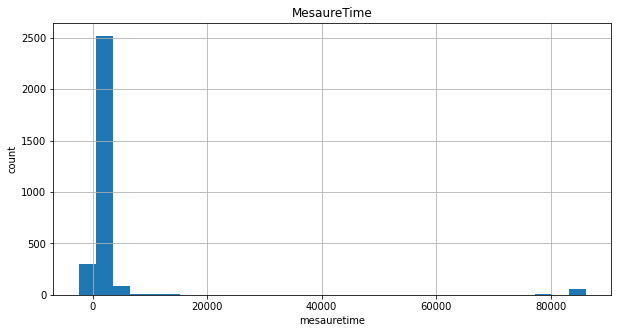

In [87]:
data_temp['MesaureTime'].hist(figsize=(10, 5), bins=30)
plt.title('MesaureTime')
plt.xlabel('mesauretime')
plt.ylabel('count')
plt.show()

In [88]:
data_temp = data_temp.query('MesaureTime > 0')

In [89]:
data_temp = data_temp.query('MesaureTime < 5000')

In [90]:
data_temp.reset_index(drop=True, inplace=True)
data_temp

,key,Temperature_max,Temperature_min,MesaureTime
0,1,1613.0,1571.0,861.0
1,2,1602.0,1581.0,1305.0
2,3,1599.0,1596.0,1300.0
3,4,1625.0,1601.0,388.0
4,5,1602.0,1576.0,762.0
...,...,...,...,...
2749,2495,1591.0,1570.0,1137.0
2750,2496,1591.0,1554.0,1618.0
2751,2497,1589.0,1571.0,717.0
2752,2498,1594.0,1591.0,1302.0


### Данные об объеме и времени подачи проволочных материалов

steel.data_wire — данные об объёме проволочных материалов:

- key — номер партии
- Wire1 … Wire15 — объём подаваемых проволочных материалов

In [91]:
query = '''SELECT *
           FROM steel.data_wire
        '''

data_wire = pd.read_sql_query(query, con=engine)

In [92]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [94]:
data_wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [95]:
data_wire.duplicated().sum()

0

steel.data_wire_time — данные о времени подачи проволочных материалов:

- key — номер партии;
- Wire1 … Wire15 — время подачи проволочных материалов

In [96]:
query = '''SELECT *
           FROM steel.data_wire_time
        '''

data_wire_time = pd.read_sql_query(query, con=engine)

In [97]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


In [98]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [99]:
data_wire_time.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [100]:
data_wire_time.duplicated().sum()

0

In [101]:
data_wire = data_wire.fillna(0)
data_wire_time = data_wire_time.fillna(0)

### Объединение данных

Объединим таблицы по ключу так, чтобы одной партии соответствовало одно наблюдение.

In [102]:
data = data_arc.merge(data_bulk, on='key', how='inner')
data = data.merge(data_temp, on='key', how='inner')
data = data.merge(data_wire, on='key', how='inner')

In [103]:
data.head(10)

,key,Duration,ApparentPower,Active/Reactive,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,MesaureTime,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,219.60,1.165279,1.538898,0.0,0.0,0.0,43.0,0.0,0.0,...,861.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,202.75,0.912304,1.551834,0.0,0.0,0.0,73.0,0.0,0.0,...,1305.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,131.00,0.597907,1.583120,0.0,0.0,0.0,34.0,0.0,0.0,...,1300.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,185.25,0.953741,1.563487,0.0,0.0,0.0,81.0,0.0,0.0,...,388.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,217.25,1.008939,1.480428,0.0,0.0,0.0,78.0,0.0,0.0,...,762.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,238.00,1.196709,1.501854,0.0,0.0,0.0,117.0,0.0,0.0,...,1385.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,168.25,0.746944,1.628748,0.0,0.0,0.0,117.0,0.0,0.0,...,1374.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,228.25,1.156847,1.486391,0.0,0.0,0.0,99.0,0.0,0.0,...,934.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,125.00,0.511070,1.421598,0.0,0.0,0.0,117.0,0.0,0.0,...,1453.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,137.50,0.641957,1.231654,0.0,0.0,0.0,0.0,0.0,0.0,...,1299.0,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2591 entries, 0 to 2590
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2591 non-null   int64  
 1   Duration         2591 non-null   float64
 2   ApparentPower    2591 non-null   float64
 3   Active/Reactive  2591 non-null   float64
 4   Bulk 1           2591 non-null   float64
 5   Bulk 2           2591 non-null   float64
 6   Bulk 3           2591 non-null   float64
 7   Bulk 4           2591 non-null   float64
 8   Bulk 5           2591 non-null   float64
 9   Bulk 6           2591 non-null   float64
 10  Bulk 7           2591 non-null   float64
 11  Bulk 8           2591 non-null   float64
 12  Bulk 9           2591 non-null   float64
 13  Bulk 10          2591 non-null   float64
 14  Bulk 11          2591 non-null   float64
 15  Bulk 12          2591 non-null   float64
 16  Bulk 13          2591 non-null   float64
 17  Bulk 14       

In [105]:
data.isna().sum()

key                0
Duration           0
ApparentPower      0
Active/Reactive    0
Bulk 1             0
Bulk 2             0
Bulk 3             0
Bulk 4             0
Bulk 5             0
Bulk 6             0
Bulk 7             0
Bulk 8             0
Bulk 9             0
Bulk 10            0
Bulk 11            0
Bulk 12            0
Bulk 13            0
Bulk 14            0
Bulk 15            0
Temperature_max    0
Temperature_min    0
MesaureTime        0
Wire 1             0
Wire 2             0
Wire 3             0
Wire 4             0
Wire 5             0
Wire 6             0
Wire 7             0
Wire 8             0
Wire 9             0
dtype: int64

Мы можем удалить номера партий и данные о времени. В нашем случае, они не несут никакой полезной информации.

In [106]:
data = data.drop(['key'], axis=1)

In [107]:
data.duplicated().sum()

0

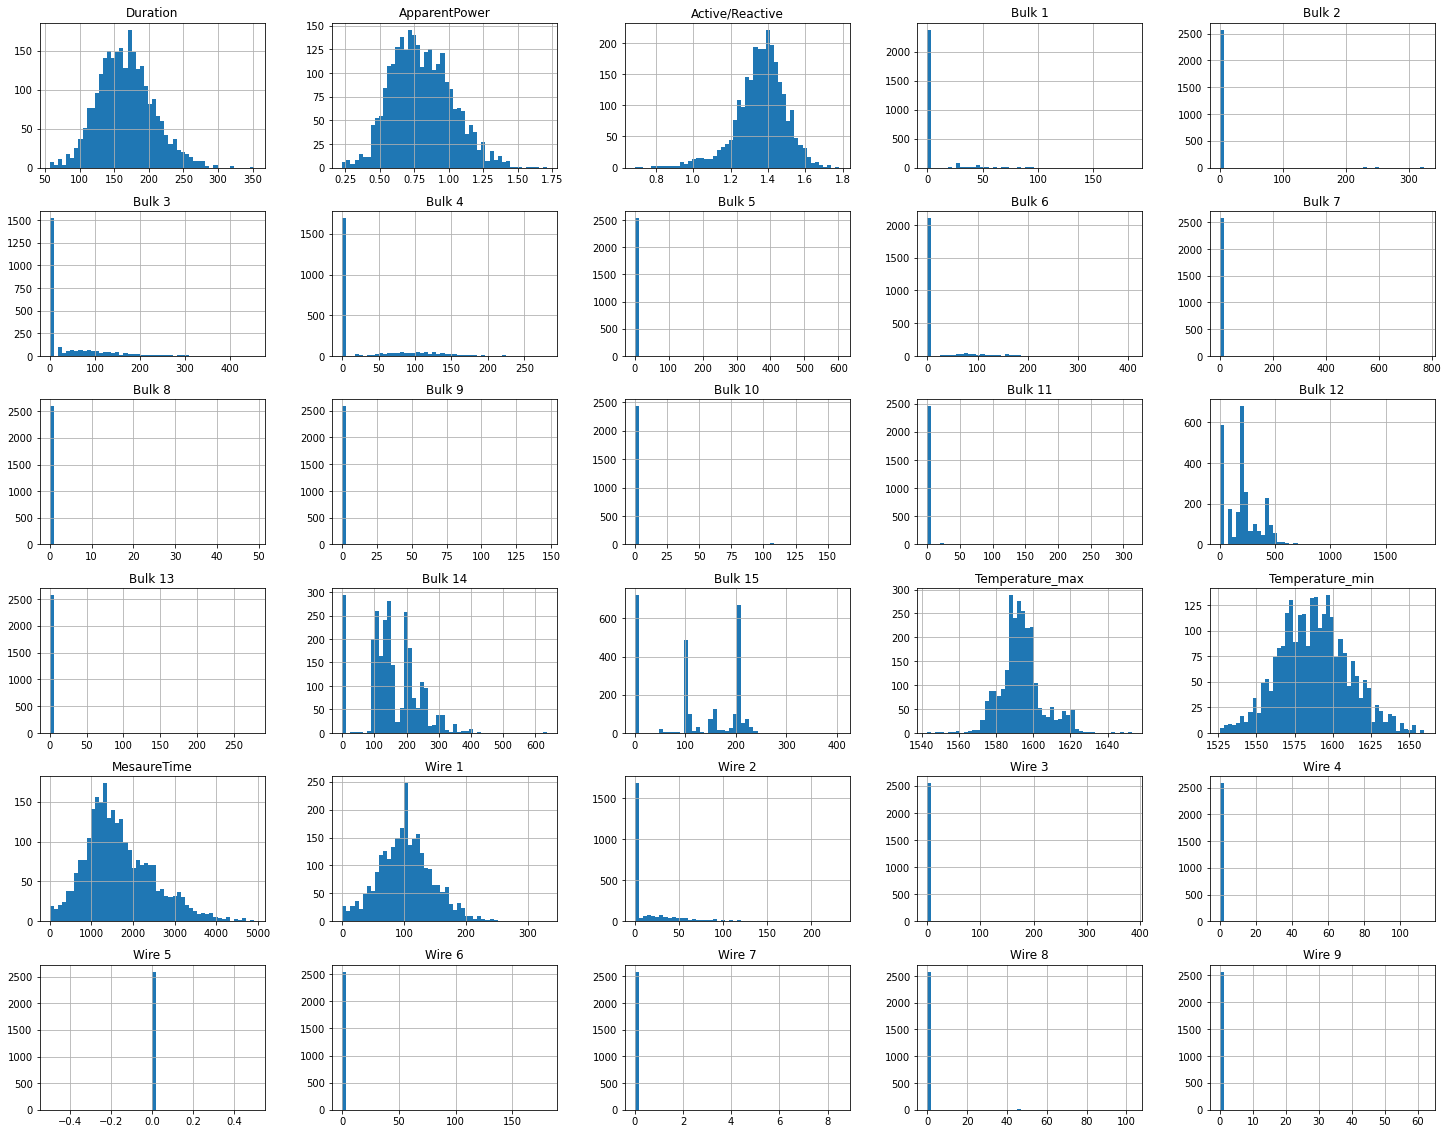

In [108]:
data.hist(figsize=(25, 20), bins=50);

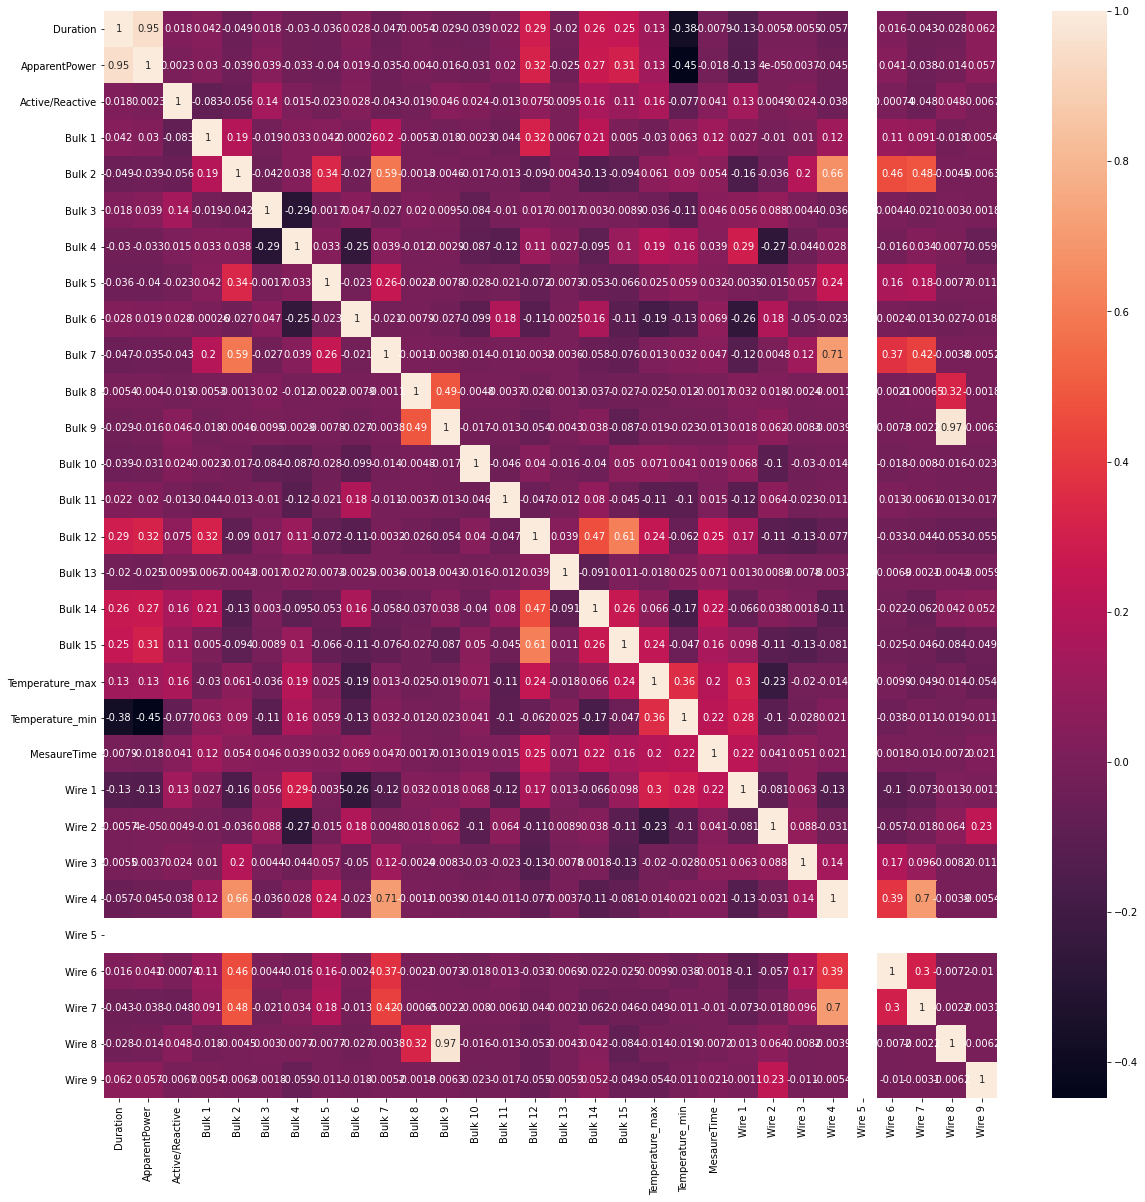

In [109]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True);

interval columns not set, guessing: ['Duration', 'ApparentPower', 'Active/Reactive', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Temperature_max', 'Temperature_min', 'MesaureTime', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']


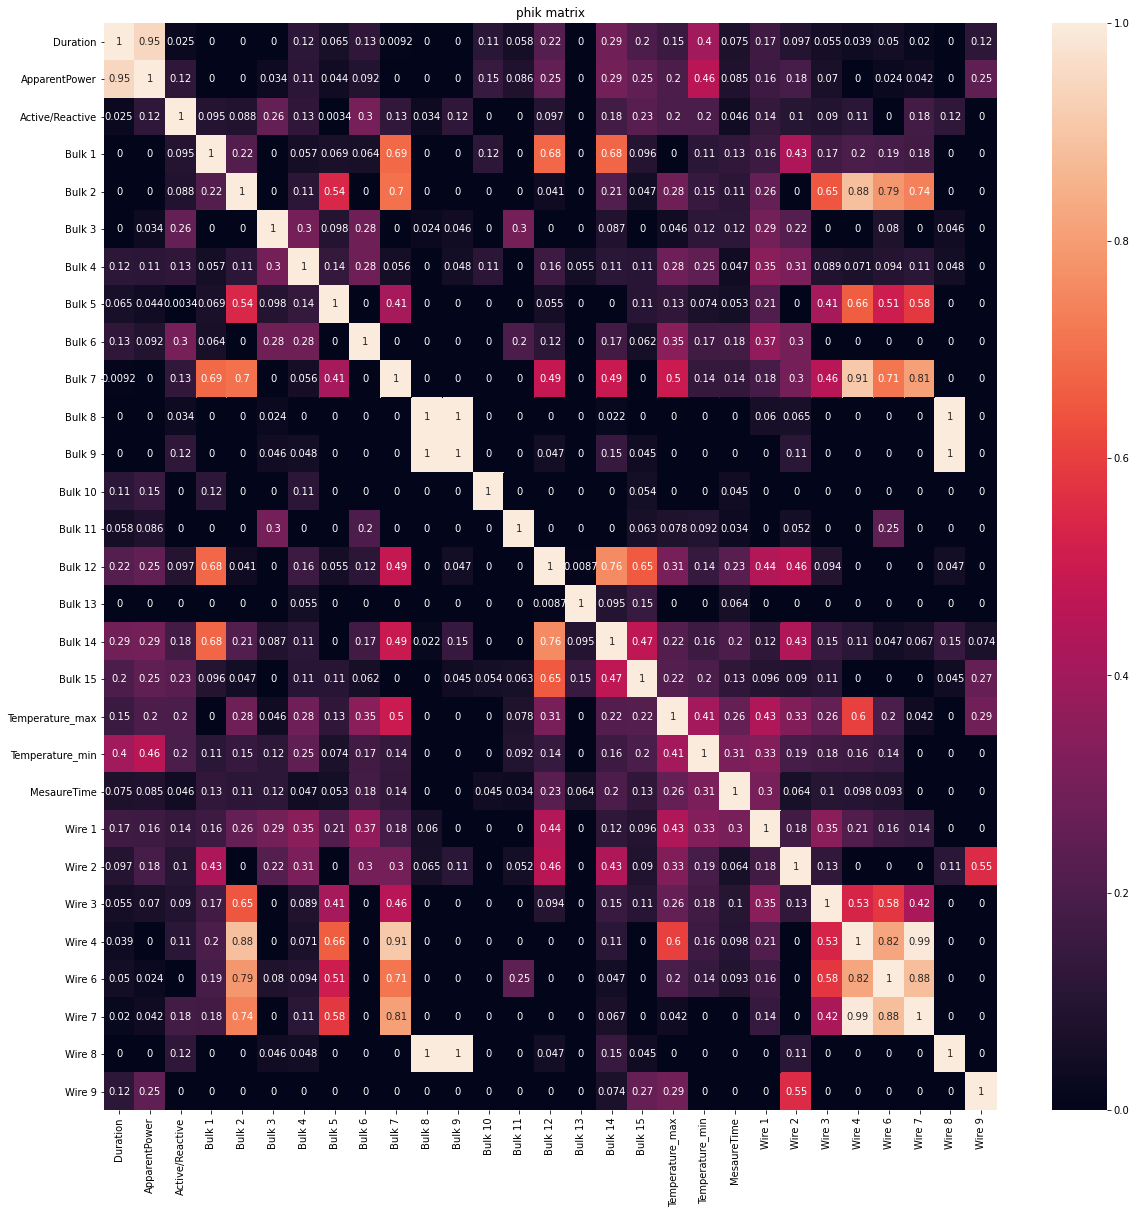

In [110]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.phik_matrix(), annot=True)
plt.title('phik matrix');

Еще раз вывели на экран распределение всех отобранных нами признаков. По гистограмам можно заметить, что данные распределяются неравномерно. Это подтверждается приведенной также тепловой картой признаков. По сути сильная корреляция присутствует только между длительностью нагрева и полной мощностью.

### Подготовка данных для обучения

Целевой признак у нас - последняя температура партии. Все остальное переведем в признаки.

In [111]:
features = data.drop(columns=['Temperature_max'], axis=1)
target = data['Temperature_max']

In [112]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            random_state=RANDOM_STATE, 
                                                                            test_size=0.25)

In [113]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1943, 29)
(648, 29)
(1943,)
(648,)


In [114]:
scaler = StandardScaler()

In [115]:
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

## Обучение моделей

Рассмотрим несколько классов обучающих моделей.

### Линейная регрессия

In [116]:
lr = LinearRegression()

lr_grid_space = {}

### Случайный лес

In [117]:
rfr = RandomForestRegressor(random_state=RANDOM_STATE)

rfr_grid_space = {'n_estimators': range(1, 40),
                  'max_depth': range(1, 15)}

### CatBoost

In [118]:
cat = CatBoostRegressor(random_state=RANDOM_STATE)

cat_grid_space = {'n_estimators': range(1, 20),
                  'max_depth': range(1, 10)}

### Подбор гиперпараметров

Для подбора гиперпараметров используем метод GridSearchCV.

In [119]:
def find_model(model, grid_space):
    grid = GridSearchCV(model, param_grid=grid_space, cv=5, n_jobs=-1, 
                        scoring='neg_mean_absolute_error', verbose=False)
    model_grid = grid.fit(features_train, target_train)
    print(abs(model_grid.best_score_))
    print(model_grid.best_params_)
    
    return model_grid

### Обучение

In [120]:
%%time

lr_model = find_model(lr, lr_grid_space)
lr_model

6.753854748324618
{}
CPU times: user 206 ms, sys: 343 ms, total: 549 ms
Wall time: 503 ms


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1, param_grid={},
             scoring='neg_mean_absolute_error', verbose=False)

In [121]:
%%time

rfr_model = find_model(rfr, rfr_grid_space)
rfr_model

6.395209480457897
{'max_depth': 13, 'n_estimators': 33}
CPU times: user 5min 11s, sys: 831 ms, total: 5min 11s
Wall time: 5min 12s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=141123),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 15),
                         'n_estimators': range(1, 40)},
             scoring='neg_mean_absolute_error', verbose=False)

In [122]:
%%time

cat_model = find_model(cat, cat_grid_space)
cat_model

Learning rate set to 0.5
0:	learn: 10.7457230	total: 47.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 10.8639495	total: 520us	remaining: 0us
Learning rate set to 0.5
0:	learn: 10.7007351	total: 524us	remaining: 0us
Learning rate set to 0.5
0:	learn: 10.9235363	total: 484us	remaining: 0us
Learning rate set to 0.5
0:	learn: 11.1192974	total: 502us	remaining: 0us
Learning rate set to 0.5
0:	learn: 10.7457230	total: 469us	remaining: 469us
1:	learn: 10.4681962	total: 1.09ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 10.8639495	total: 473us	remaining: 473us
1:	learn: 10.5771146	total: 1.21ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 10.7007351	total: 467us	remaining: 467us
1:	learn: 10.4469438	total: 1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 10.9235363	total: 511us	remaining: 511us
1:	learn: 10.6735548	total: 993us	remaining: 0us
Learning rate set to 0.5
0:	learn: 11.1192974	total: 523us	remaining: 523us
1:	learn: 10.7092893	total: 1.1ms	remaining: 0us
Lear

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fdbf3de0370>,
             n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(1, 20)},
             scoring='neg_mean_absolute_error', verbose=False)

### Полносвязная нейронная сеть

In [123]:
X_train = torch.Tensor(features_train)
y_train = torch.Tensor(target_train.values)
X_test = torch.Tensor(features_test)
y_test = torch.Tensor(target_test.values)

In [124]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons = 500
n_hidden_neurons_1 = 300
n_out_neurons = 1

In [125]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

In [126]:
net = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons, n_hidden_neurons_1),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_1, n_out_neurons),
            nn.ReLU()
            )

In [127]:
torch_net = NeuralNetRegressor(net, criterion=nn.MSELoss, optimizer=optim.Adam, verbose=False)

torch_grid_space = {'batch_size': [50], 
                    'max_epochs': [200]}

In [128]:
def find_model(model, grid_space):
    grid = GridSearchCV(model, param_grid=grid_space, cv=5, n_jobs=-1, 
                        scoring='neg_mean_absolute_error', verbose=False)
    model_grid = grid.fit(X_train, y_train)
    print(abs(model_grid.best_score_))
    print(model_grid.best_params_)
    
    return model_grid

In [129]:
%%time

torch_model = find_model(torch_net, torch_grid_space)
torch_model

25.71848068237305
{'batch_size': 50, 'max_epochs': 200}
CPU times: user 7min 8s, sys: 1.21 s, total: 7min 9s
Wall time: 7min 12s


GridSearchCV(cv=5,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=Sequential(
    (0): Linear(in_features=29, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=1, bias=True)
    (5): ReLU()
  ),
),
             n_jobs=-1, param_grid={'batch_size': [50], 'max_epochs': [200]},
             scoring='neg_mean_absolute_error', verbose=False)

### Результаты

In [130]:
results = pd.DataFrame([[abs(lr_model.best_score_)], 
                        [abs(rfr_model.best_score_)], 
                        [abs(cat_model.best_score_)], 
                        [abs(torch_model.best_score_)]], 
                       columns=['mae'], 
                       index=['LinearRegression', 
                              'RandomForest', 
                              'CatBoost', 
                              'Torch net']).sort_values(by='mae')

results

,mae
RandomForest,6.395209
CatBoost,6.554555
LinearRegression,6.753855
Torch net,25.718481


Лучший результат показала модель случайного леса. Она уложилась в необходмый результат по MAE.

(здесь может меняться порядок, т.к. результаты нейросети могут меняться при каждом запуске процесса обучения)

## Тестирование модели

In [131]:
test_model = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=200, max_depth=10)
test_model.fit(features_train, target_train)
predictions = test_model.predict(features_test)
mae = mean_absolute_error(target_test, predictions)
r2 = r2_score(target_test, predictions)
print(mae)
print(r2)

6.723909701004077
0.3732400998410149


Модель случайного леса на тестовых данных подтвердила необходимое качество, показав результат по MAE 6.5. Однако метрика R2 оказалось очень низкой, что говорит о том, что модель не сильно соответствует своему набору данных.

Проверка на константной модели также подтвердила качество по MAE.

In [132]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)
predictions = dummy.predict(features_test)
mae = mean_absolute_error(target_test, predictions)
r2 = r2_score(target_test, predictions)
print(mae)
print(r2) 

8.367576231232094
-0.0003415672108972867


Можно сделать вывод, что наибольшее важным признаком для нашей модели является начальная температура нагрева. Также заметное значение имеют объемы подаваемых в начале сыпучих и проволочных материалов. Стоит обращать внимание на полную мощность.

In [133]:
importances = test_model.feature_importances_
importances = pd.Series(importances, features.columns)
importances.sort_values(ascending=False)

Temperature_min    0.190705
Wire 1             0.124122
ApparentPower      0.094424
Bulk 12            0.089435
Active/Reactive    0.081126
MesaureTime        0.072247
Wire 2             0.068229
Bulk 14            0.057636
Duration           0.045930
Bulk 15            0.043721
Bulk 6             0.036407
Bulk 7             0.020571
Bulk 3             0.019337
Bulk 4             0.018481
Bulk 1             0.015232
Bulk 11            0.005751
Wire 4             0.003834
Wire 6             0.002881
Bulk 5             0.002676
Bulk 10            0.002577
Wire 9             0.001468
Wire 3             0.001354
Bulk 2             0.001169
Bulk 13            0.000245
Wire 7             0.000204
Bulk 9             0.000128
Wire 8             0.000105
Bulk 8             0.000004
Wire 5             0.000000
dtype: float64

Для примера рассмотрим распределение начальной температуры от конечной. Полученный график говорит о более широков распределении начальной температуры. Можно отметить большоую плотность данных в диапазоне 1580-1600 градусов.

Ниже для наглядности приведем графики для двух других признаков - объемы подаваемых в начале процесса сыпучих и проволочных материалов.

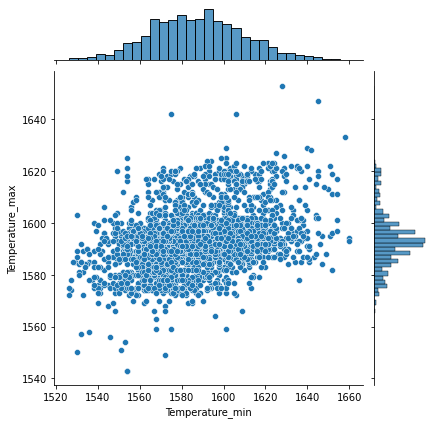

In [134]:
sns.jointplot(data=data, x='Temperature_min', y='Temperature_max');

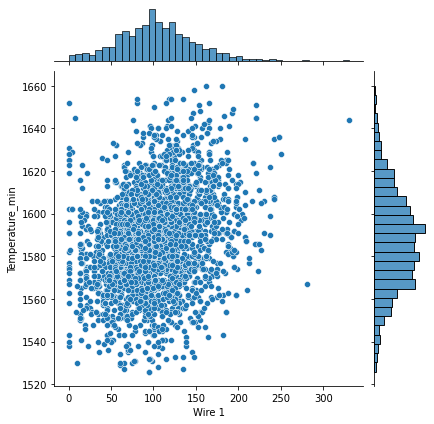

In [135]:
sns.jointplot(data=data, x='Wire 1', y='Temperature_min');

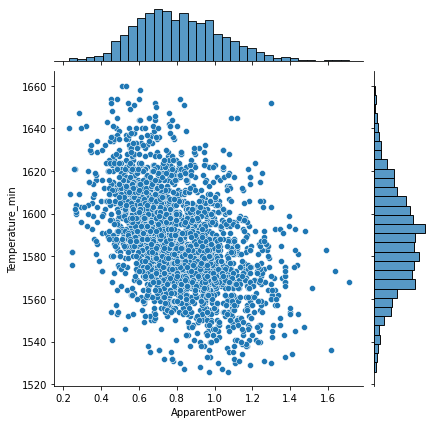

In [136]:
sns.jointplot(data=data, x='ApparentPower', y='Temperature_min');

## Итоговый вывод

Наша задача заключалась в разработке модели предсказания температуры сплава в процессе обработки стали. Значение метрики MAE должно быть ниже 6.8.


Мы проверили имеющиеся данные на наличие пропусков и повторов. Провели обработку от выбросов и редких значений. На основе этих данных мы рассчитали новые признаки - полную мощность и время нагрева сплава, определили значения температуры партии на начальном и конечном этапах обработки.


Данные оказались распределены неравномерно. По сути серьезная корреляция есть только между полной мощностью и временем нагрева. С этим же признаками заметно коррелирует начальная температура сплава.


По итогам обучения лучший результат показала модель случайного леса. Она прошла проверку на тестовых данных. Итоговая метрика MAE равна 6.5, она уложилась в необходимую границу. Этот результат лучше результата константной модели. Однако расчет метрики R2 показал слабое соответствие модели набору данных.


Мы можем сделать вывод, что наибольшее значение на основе представленных данных имеют начальные, входные параметры, такие как начальная температура сплава, объем подачи первой партии сыпучих и проволочных материалов. Возможно, нам не хватило каких-то дополнительных данных для построения более точной модели, учитывая большое количество пропусков и выбросов в данных.


Но в целом можно сделать вывод, что для бизнеса основное значение имеет контроль того, при какой температуре и какой объем материалов подается на начальном этапе обработки стали.